## Medical image segmentation: segmentation of skin lesion dataset using DAU-Net network
> **步骤：**

> 1. Editing environment
> 2. Data pre-processing
> 3. Data visualisation
> 4. Establishment of DAU-Net network
> 5. Network Preprocessing
> 6. Network Training and Testing
> 7. Perception

In [1]:
# Importing related packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import glob
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import albumentations as A
import os
import cv2
import random
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from torchvision import transforms as T
import torch.optim as optim
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Check cpu/gpu count, set random number seed

In [2]:
from multiprocessing import cpu_count
num_processes = cpu_count()
print(f'CPU found: {num_processes}')
print(f'{torch.cuda.device_count()} GPU found: {torch.cuda.get_device_name("cuda")}')

CPU found: 2
2 GPU found: Tesla T4


In [3]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [4]:
# Setting a random number of seeds, 42 is said to be an auspicious number to achieve good results
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

## Data preprocessing
1. Obtain image paths and divide them into training and testing validation sets.
2. Preprocess the images, e.g. randomly change the brightness, contrast and saturation.
3. custom Dataset function

In [5]:
# Get Image Path
def data_preparation():  
    root = '../input/isic2018step1segmentation'

    input_data = os.path.join(root, 'ISIC2018_inputs')
    inputs_paths = glob.glob(input_data+'/*')
    
    target_data = os.path.join(root,'ISIC2018_targets')
    targets_paths = glob.glob(target_data+'/*')
    
    return sorted(inputs_paths),sorted(targets_paths)

image, mask = data_preparation()
# metric
print(image[5:8])
print(mask[5:8])

['../input/isic2018step1segmentation/ISIC2018_inputs/ISIC_0000007.jpg', '../input/isic2018step1segmentation/ISIC2018_inputs/ISIC_0000008.jpg', '../input/isic2018step1segmentation/ISIC2018_inputs/ISIC_0000009.jpg']
['../input/isic2018step1segmentation/ISIC2018_targets/ISIC_0000007_segmentation.png', '../input/isic2018step1segmentation/ISIC2018_targets/ISIC_0000008_segmentation.png', '../input/isic2018step1segmentation/ISIC2018_targets/ISIC_0000009_segmentation.png']


In [6]:
# Divide the data set
df = pd.DataFrame(data={'image':image,'mask':mask},index=None)
df = df.sample(frac=1).reset_index(drop=True)  # 打乱数据集并重置索引

length_train = int(df.shape[0]*0.8)
length_val = int(df.shape[0]*0.1)

df_train = df.iloc[:length_train,:]
df_val = df.iloc[length_train:length_train+length_val,:]
df_test = df.iloc[length_train+length_val:,:]
print(df_train.shape,df_val.shape,df_test.shape)

(2075, 2) (259, 2) (260, 2)


In [7]:
# Note that the width and height are multiples of 16, and the network is downsampled 4 times
strong_transforms = A.Compose([
    A.Resize(width = 256//2, height = 192//2, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
   # Pixels
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.05, blur_limit = 3),
    A.CLAHE(p=0.15),            # Adaptive Histogram Equalisation
    A.Sharpen(p=0.15),          # Sharpen the input image and overlay the result with the original image
    
    A.OneOf([
        A.ChannelShuffle(p=0.15),   # Randomly rearranges the channels of the input RGB image
        A.ColorJitter(p=0.45),      # Randomly change the brightness, contrast and saturation of an image
        A.FancyPCA(p=0.25),         # Enhancing RGB images with FancyPCA
        A.HueSaturationValue(p=0.15),    # Randomly change the hue, saturation and value of the input image
    ],p=1.0)
])

normal_transforms = A.Compose([
    A.Resize(width = 256//2, height = 192//2, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

## Building data pipelines

In [8]:
class ISICDataset(Dataset):
    def __init__(self, df ,transform):
        self.df = df
        self.transform = transform
        self.to_tensor = T.ToTensor()
        
    def __getitem__(self,index):
        img = self.df.iloc[index,0]
        label = self.df.iloc[index,1]
        
        img_open = Image.open(img).convert('RGB')
        img_open = np.array(img_open)
        
        label_open = Image.open(label).convert('L')
        label_open = np.array(label_open)
        arg = self.transform(image=img_open,mask=label_open)
        
        return self.to_tensor(arg['image']),self.to_tensor(arg['mask'])
    def __len__(self):
        return self.df.shape[0]

In [10]:
# The larger the batch_size the better, at least 2
train_data = ISICDataset(df_train, strong_transforms)
val_data = ISICDataset(df_val, normal_transforms)
test_data = ISICDataset(df_test, normal_transforms)

dl_train = DataLoader(train_data,batch_size=8,shuffle=True,num_workers=4, pin_memory=True,drop_last=True)
dl_val = DataLoader(val_data,batch_size=8,shuffle=True,num_workers=4, pin_memory=True,drop_last=True)
dl_test = DataLoader(test_data,batch_size=8,shuffle=True,num_workers=4, pin_memory=True,drop_last=True)

print(len(dl_train),len(dl_val),len(dl_test))

259 32 32


torch.Size([8, 3, 96, 128]) torch.Size([8, 1, 96, 128])
0.9607843 0.31764707
1.0 0.0
1.0 0.0
1.0 0.0


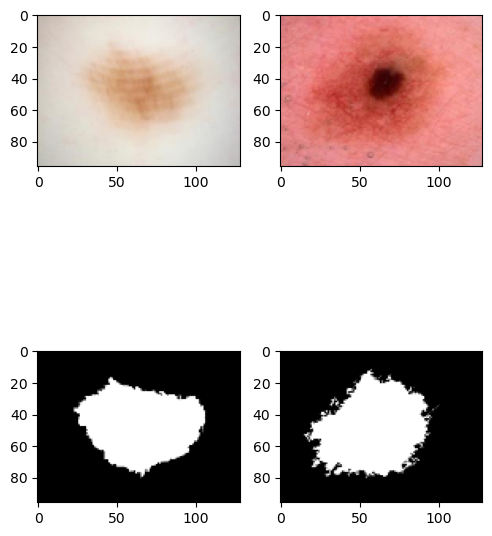

In [11]:
# test
img,label = next(iter(dl_val))
print(img.shape,label.shape)
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
for i,data in enumerate(zip(img[:2],label[:2])):
    img,label = data
    img = img.numpy().transpose(1,2,0)
    label = label.squeeze().numpy()
    print(img.max(),img.min())
    print(label.max(),label.min())
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.subplot(2,4,i+5)
    plt.imshow(label,cmap='gray')
plt.show()

## Establishment of DAUNet network

In [12]:
from torchvision.ops import DeformConv2d

class connection(nn.Module):
    def __init__(self, in_ch, ou_ch):
        super(connection, self).__init__()

        self.conv3_3 = nn.Conv2d(in_ch, ou_ch // 2, kernel_size=3, padding=1)
        self.conv1_1 = nn.Conv2d(in_ch, ou_ch // 2, kernel_size=1)

    def forward(self, x):
        x1 = self.conv3_3(x)
        x2 = self.conv1_1(x)
        x = torch.cat([x1, x2], dim=1)
        return x


class conn1(nn.Module):
    def __init__(self, in_ch, ou_ch):
        super(conn1, self).__init__()

        self.conn = connection(in_ch, ou_ch)
        self.conn1 = connection(ou_ch, ou_ch)

    def forward(self, x):
        x1 = self.conn(x)
        return self.conn1(x1)


class conn2(nn.Module):
    def __init__(self, in_ch, ou_ch):
        super(conn2, self).__init__()

        self.conn = connection(in_ch, ou_ch)
        self.conn1 = connection(ou_ch, ou_ch)

        self.conn2 = connection(ou_ch, ou_ch)
        self.conn3 = connection(ou_ch, ou_ch)

    def forward(self, x):
        x1 = self.conn(x)
        x2 = self.conn1(x1)
        x3 = self.conn2(x2)
        return self.conn3(x3)


class conn3(nn.Module):
    def __init__(self, in_ch, ou_ch):
        super(conn3, self).__init__()
        self.conn = connection(in_ch, ou_ch)
        self.conn1 = connection(ou_ch, ou_ch)

        self.conn2 = connection(ou_ch, ou_ch)
        self.conn3 = connection(ou_ch, ou_ch)

        self.conn4 = connection(ou_ch, ou_ch)
        self.conn5 = connection(ou_ch, ou_ch)

    def forward(self, x):
        x1 = self.conn(x)
        x2 = self.conn1(x1)
        x3 = self.conn2(x2)
        x4 = self.conn3(x3)
        x5 = self.conn4(x4)
        return self.conn5(x5)


class conn4(nn.Module):
    def __init__(self, in_ch, ou_ch):
        super(conn4, self).__init__()
        self.conn = connection(in_ch, ou_ch)
        self.conn1 = connection(ou_ch, ou_ch)

        self.conn2 = connection(ou_ch, ou_ch)
        self.conn3 = connection(ou_ch, ou_ch)

        self.conn4 = connection(ou_ch, ou_ch)
        self.conn5 = connection(ou_ch, ou_ch)

        self.conn6 = connection(ou_ch, ou_ch)
        self.conn7 = connection(ou_ch, ou_ch)

    def forward(self, x):
        x1 = self.conn(x)
        x2 = self.conn1(x1)
        x3 = self.conn2(x2)
        x4 = self.conn3(x3)
        x5 = self.conn4(x4)
        x6 = self.conn5(x5)
        x7 = self.conn6(x6)
        return self.conn7(x7)

class attention2d(nn.Module):
    def __init__(self, in_planes, K, ):
        super(attention2d, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, K, 1)
        self.fc2 = nn.Conv2d(K, K, 1)

    def forward(self, x):
        x = self.avgpool(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x).view(x.size(0), -1)
        return F.softmax(x, 1)
    
class Adaptive_conv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, K=4, ):
        super(Adaptive_conv2d, self).__init__()
        assert in_planes % groups == 0  # Ensure that the number of input channels is divisible by the number of groups
        self.in_planes = in_planes  # Number of input channels
        self.out_planes = out_planes  # Number of output channels
        self.kernel_size = kernel_size  # Kernel size of the convolution
        self.stride = stride  # Stride
        self.padding = padding  # Padding
        self.dilation = dilation  # Dilation
        self.groups = groups  # Number of groups = batch_size
        self.bias = bias  # Whether to include bias
        self.K = K  # Number of dynamic convolutional weights
        self.attention = attention2d(in_planes, K, )  # Create an attention mechanism object

        self.weight = nn.Parameter(
            torch.Tensor(K, self.out_planes, in_planes // groups, kernel_size, kernel_size),
            requires_grad=True)  # Dynamic convolution weight parameters, defined as trainable
        if bias:
            self.bias = nn.Parameter(torch.Tensor(K, out_planes))  # If bias is included, it's defined as trainable
        else:
            self.bias = None  # Otherwise, it's set to None

    def forward(self, x):
        # Treat the batch as a dimension variable to perform group convolution, as the weights for group convolution are different,
        # and the weights for dynamic convolution are also different
        softmax_attention = self.attention(x)  # Calculate attention scores using the attention mechanism
        batch_size, in_planes, height, width = x.size()  # Get the shape information of the input tensor
        x = x.view(1, -1, height, width)  # Reshape the input tensor to a single dimension for group convolution
        weight = self.weight.view(self.K, -1)  # Reshape the weight tensor to fit dynamic convolution

        # Generate dynamic convolution weights; it generates batch_size convolution parameters (each parameter is different)
        aggregate_weight = torch.mm(softmax_attention, weight).view(-1, self.in_planes, self.kernel_size,
                                                                    self.kernel_size)
        if self.bias is not None:
            aggregate_bias = torch.mm(softmax_attention, self.bias).view(-1)  # Calculate dynamic bias
            output = F.conv2d(x, weight=aggregate_weight, bias=aggregate_bias, stride=self.stride, padding=self.padding,
                              dilation=self.dilation, groups=self.groups * batch_size)  # Perform dynamic convolution
        else:
            output = F.conv2d(x, weight=aggregate_weight, bias=None, stride=self.stride, padding=self.padding,
                              dilation=self.dilation, groups=self.groups * batch_size)

        output = output.view(batch_size, self.out_planes, output.size(-2),
                             output.size(-1))  # Reshape the output tensor's shape
        return output

class CBAMLayer(nn.Module):
    def __init__(self, channel, reduction=16, spatial_kernel=7):
        super(CBAMLayer, self).__init__()
        # channel attention 压缩H,W为1
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # shared MLP
        self.mlp = nn.Sequential(
            # Conv2d比Linear方便操作
            # nn.Linear(channel, channel // reduction, bias=False)
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            # inplace=True直接替换，节省内存
            nn.ReLU(inplace=True),
            # nn.Linear(channel // reduction, channel,bias=False)
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        # spatial attention
        self.conv = nn.Conv2d(2, 1, kernel_size=spatial_kernel,
                              padding=spatial_kernel // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_out = self.mlp(self.max_pool(x))
        avg_out = self.mlp(self.avg_pool(x))
        channel_out = self.sigmoid(max_out + avg_out)
        x = channel_out * x
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        spatial_out = self.sigmoid(self.conv(torch.cat([max_out, avg_out], dim=1)))
        x = spatial_out * x
        return x

class Double_Deform_Block(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1_ = nn.Conv2d(in_channels, 2 * 3 * 3, kernel_size=3, stride=1, padding=1)
        self.conv1 = DeformConv2d(in_channels, middle_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2_ = nn.Conv2d(middle_channels, 2 * 3 * 3, kernel_size=3, stride=1, padding=1)
        self.conv2 = DeformConv2d(middle_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        offset1 = self.conv1_(x)
        out = self.conv1(x, offset1)
        out = self.bn1(out)
        out = self.relu(out)

        offset2 = self.conv2_(out)
        out = self.conv2(out, offset2)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class Double_Normal_Block(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out

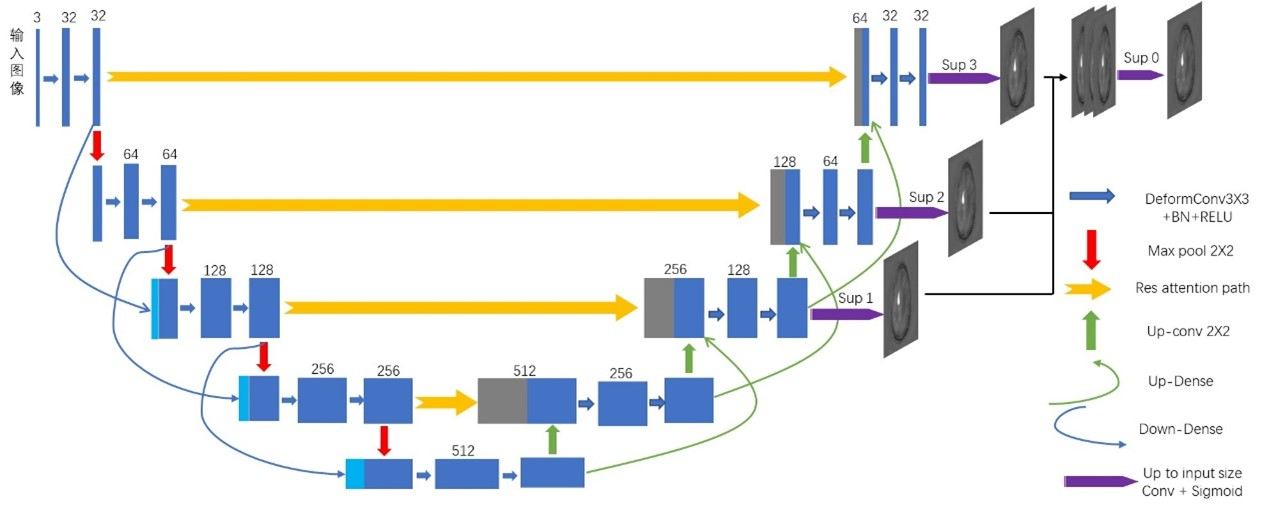

In [13]:
class Deform_Adaptive_UNet(nn.Module):
    def __init__(self, input_channels, num_classes, deep=True):
        super(Deform_Adaptive_UNet, self).__init__()

        nb_filter = [16, 32, 64, 128, 256]

        self.deep = deep

        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool4 = nn.MaxPool2d(4, 4)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # scale_factor:放大的倍数  插值
        self.up4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)  # scale_factor:放大的倍数  插值

        # encode
        self.conv0_0 = Double_Deform_Block(input_channels, (input_channels + nb_filter[0]) // 2,
                                           nb_filter[0])

        self.conv1_0 = Double_Deform_Block(nb_filter[0], (nb_filter[0] + nb_filter[1]) // 2,
                                           nb_filter[1])

        self.conv2_0 = Double_Normal_Block(nb_filter[1] + nb_filter[1],
                                           (nb_filter[1] + nb_filter[1] + nb_filter[2]) // 2,
                                           nb_filter[2])

        self.conv3_0 = Double_Normal_Block(nb_filter[2] + nb_filter[2],
                                           (nb_filter[2] + nb_filter[2] + nb_filter[3]) // 2,
                                           nb_filter[3])

        self.conv4_0 = Double_Normal_Block(nb_filter[3] + nb_filter[3],
                                           (nb_filter[3] + nb_filter[3] + nb_filter[4]) // 2,
                                           nb_filter[4])

        self.down_dense1 = nn.Conv2d(nb_filter[0], nb_filter[1], kernel_size=1)
        self.down_dense2 = nn.Conv2d(nb_filter[1], nb_filter[2], kernel_size=1)
        self.down_dense3 = nn.Conv2d(nb_filter[2], nb_filter[3], kernel_size=1)

        # connection
        self.connect1 = conn1(nb_filter[3], nb_filter[3])
        self.connect2 = conn2(nb_filter[2], nb_filter[2])
        self.connect3 = conn3(nb_filter[1], nb_filter[1])
        self.connect4 = conn4(nb_filter[0], nb_filter[0])
        self.cbam3_1 = CBAMLayer(128)
        self.cbam2_2 = CBAMLayer(64)
        self.cbam1_3 = CBAMLayer(32)
        self.cbam0_4 = CBAMLayer(16)

        # decode
        self.conv3_1 = Double_Normal_Block(nb_filter[3] + nb_filter[4],
                                           (nb_filter[3] + nb_filter[4] + nb_filter[3]) // 2,
                                           nb_filter[3])

        self.conv2_2 = Double_Normal_Block(nb_filter[2] + nb_filter[3],
                                           (nb_filter[2] + nb_filter[3] + nb_filter[2]) // 2,
                                           nb_filter[2])

        self.conv1_3 = Double_Deform_Block(nb_filter[1] + nb_filter[2],
                                           (nb_filter[1] + nb_filter[2] + nb_filter[1]) // 2,
                                           nb_filter[1])

        self.conv0_4 = Double_Deform_Block(nb_filter[0] + nb_filter[1],
                                           (nb_filter[0] + nb_filter[1] + nb_filter[0]) // 2,
                                           nb_filter[0])

        self.up_dense1 = nn.Conv2d(nb_filter[4], nb_filter[3], kernel_size=1)
        self.up_dense2 = nn.Conv2d(nb_filter[3], nb_filter[2], kernel_size=1)
        self.up_dense3 = nn.Conv2d(nb_filter[2], nb_filter[1], kernel_size=1)

        # deep sup
        self.deep_conv2 = nn.Conv2d(nb_filter[2],num_classes,kernel_size=1)
        self.deep_conv3 = nn.Conv2d(nb_filter[1],num_classes,kernel_size=1)
        self.deep_conv4 = nn.Conv2d(nb_filter[0],num_classes,kernel_size=1)

        self.final = nn.Conv2d(num_classes*3, num_classes, kernel_size=1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)

        x1_0 = self.conv1_0(self.pool2(x0_0))

        x2_0 = self.conv2_0(torch.cat([self.down_dense1(self.pool4(x0_0)), self.pool2(x1_0)], dim=1))

        x3_0 = self.conv3_0(torch.cat([self.down_dense2(self.pool4(x1_0)), self.pool2(x2_0)], dim=1))

        x4_0 = self.conv4_0(torch.cat([self.down_dense3(self.pool4(x2_0)), self.pool2(x3_0)], dim=1))

        x3_1 = self.conv3_1(torch.cat([self.cbam3_1(self.connect1(x3_0)), self.up2(x4_0)], 1))

        x2_2 = self.conv2_2(
            torch.cat([self.cbam2_2(self.connect2(x2_0)),
                       self.up2(x3_1) + self.up_dense1(self.up4(x4_0))], 1))

        x1_3 = self.conv1_3(
            torch.cat([self.cbam1_3(self.connect3(x1_0)),
                       self.up2(x2_2) + self.up_dense2(self.up4(x3_1))], 1))

        x0_4 = self.conv0_4(
            torch.cat([self.cbam0_4(self.connect4(x0_0)),
                       self.up2(x1_3) + self.up_dense3(self.up4(x2_2))], 1))

        if self.deep:
            sup3 = self.deep_conv2(self.up4(x2_2))

            sup2 = self.deep_conv3(self.up2(x1_3))

            sup1 = self.deep_conv4(x0_4)

            output = self.final(torch.cat([sup3, sup2, sup1], dim=1))
            return torch.sigmoid(sup3), torch.sigmoid(sup2), torch.sigmoid(sup1), torch.sigmoid(output)

        else:
            output = self.deep_conv4(x0_4)
            return torch.sigmoid(output)

## training network

In [14]:
# model and device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Deform_Adaptive_UNet(3,1).to(device)

In [15]:
# GPU parallel training can be used to increase training speed if multiple gpu's are available
# I'm not in a position to do that.
# import torch.backends.cudnn as cudnn
# model = torch.nn.DataParallel(model,device_ids=[0,1]).cuda()
# cudnn.benchmark = True

# test model output
inputs = torch.ones((24,3,256,256),dtype=torch.float32).cuda()
for i in model(inputs):
    print(i.shape)

torch.Size([24, 1, 256, 256])
torch.Size([24, 1, 256, 256])
torch.Size([24, 1, 256, 256])
torch.Size([24, 1, 256, 256])


In [26]:
# Load weights, here gpu training time is limited, I divided into two training
model_path = '/kaggle/input/isic-daunet/DAUnet_best.pth'
model_dict      = model.state_dict()
pretrained_dict = torch.load(model_path, map_location = device)
load_key, no_load_key, temp_dict = [], [], {}
for k, v in pretrained_dict.items():
    if k in model_dict.keys() and np.shape(model_dict[k]) == np.shape(v):
        temp_dict[k] = v
        load_key.append(k)
    else:
        no_load_key.append(k)
model_dict.update(temp_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

## Loss Functions and Optimisers

In [18]:
# Loss Functions
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, logits=False, sampling='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.sampling = sampling

    def forward(self, y_pred, y_true):
        alpha = self.alpha
        alpha_ = (1 - self.alpha)
        if self.logits:
            y_pred = torch.sigmoid(y_pred)

        pt_positive = torch.where(y_true == 1, y_pred, torch.ones_like(y_pred))
        pt_negative = torch.where(y_true == 0, y_pred, torch.zeros_like(y_pred))
        pt_positive = torch.clamp(pt_positive, 1e-3, .999)
        pt_negative = torch.clamp(pt_negative, 1e-3, .999)
        pos_ = (1 - pt_positive) ** self.gamma
        neg_ = pt_negative ** self.gamma

        pos_loss = -alpha * pos_ * torch.log(pt_positive)
        neg_loss = -alpha_ * neg_ * torch.log(1 - pt_negative)
        loss = pos_loss + neg_loss

        if self.sampling == "mean":
            return loss.mean()
        elif self.sampling == "sum":
            return loss.sum()
        elif self.sampling is None:
            return loss
        
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth
    
    inputs = torch.where(inputs>=0.5,1,0)
    intersection1 = 2.0 * ((target * inputs).sum()) + smooth
    union1 = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union) + 1 - (intersection1 / union1)


class Focal_dice_loss(nn.Module):
    def __init__(self):
        super(Focal_dice_loss, self).__init__()
        
    def forward(self,inputs, target):
        dicescore = dice_coef_loss(inputs, target)
        focusloss = FocalLoss()(inputs,target)
        return dicescore + focusloss

# test
a = torch.ones((4,1,32,32))
b = torch.zeros((4,1,32,32))
focal_loss = FocalLoss()(a,b)
dice_loss = dice_coef_loss(a,b)
focal_dice_loss = Focal_dice_loss()(a,b)
print(focal_loss,dice_loss,focal_dice_loss)

tensor(5.1705) tensor(2.) tensor(7.1705)


## evaluation function

In [35]:
# evaluation function
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0
    
    return (intersection / union)

def iou_coef_metric(output, target):
    intersection = ((output==1) & (target==1)).sum()
    union = ((output==1) | (target==1)).sum()
    
    if target.sum() == 0 and output.sum() == 0:
        return 1.0
    
    return (intersection/ union)

**`注意`**:The following can use gpu acceleration
1. network model 
2. Data (input, labelling) 
3. loss function 

In [20]:
# Loss functions, optimisers and learning rates
criterion = Focal_dice_loss()
criterion = criterion.to(device)

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9, last_epoch=-1)

In [21]:
def model_train(net, dl_train, optimizer, criterion, epoch, Epoch, deep=False):
    loss_total = 0
    dice_total = 0
    iou_total = 0
    
    pbar = tqdm(dl_train)
    index = 0
    for data in pbar:
        train_images, labels = data
        train_images = train_images.to(device)
        labels = labels.to(device)
        outputs = net(train_images)
        # Models use deep supervision
        loss_sum = torch.tensor(0.).to(device)
        if deep:
            w = 0.
            for output in outputs:
                w += 0.2
                loss = criterion(output, labels)
                loss_sum += (w * loss)
            np_outputs = np.copy(outputs[-1].data.cpu().numpy())
        else:
            loss = criterion(outputs, labels)
            loss_sum += loss
            np_outputs = np.copy(outputs.data.cpu().numpy())

        np_labels = np.copy(labels.data.cpu().numpy())

        np_outputs[np.nonzero(np_outputs < 0.5)] = 0.0
        np_outputs[np.nonzero(np_outputs >= 0.5)] = 1.0

        dice = dice_coef_metric(np_outputs, np_labels)
        iou = iou_coef_metric(np_outputs, np_labels)

        optimizer.zero_grad()
        loss_sum.backward()
        optimizer.step()
        
        loss_total += loss_sum.item()
        dice_total += dice
        iou_total += iou
        index += 1
        pbar.set_description(f'Epoch [{epoch+1}/{Epoch}]')
        pbar.set_postfix(**{'total_loss': loss_total/index, 
                            'dice'  : dice_total/index, 
                            'lr'    : optimizer.param_groups[0]['lr']})
    scheduler.step()
    return loss_total/index,dice_total/index,iou_total/index


def model_test(net, dl_test, criterion,epoch,Epoch,deep=False):
    loss_total = 0
    dice_total = 0
    iou_total = 0
    
    index = 0
    with torch.no_grad():
        pbar = tqdm(dl_test)
        for data in pbar:
            test_images, labels = data
            test_images = test_images.to(device)
            labels = labels.to(device)
            outputs = net(test_images)
            if deep:
                outputs = outputs[-1]
            loss = criterion(outputs, labels)

            np_labels = np.copy(labels.data.cpu().numpy())
            np_outputs = np.copy(outputs.data.cpu().numpy())
            np_outputs[np.nonzero(np_outputs < 0.48)] = 0.0
            np_outputs[np.nonzero(np_outputs >= 0.48)] = 1.0

            dice = dice_coef_metric(np_outputs, np_labels)
            iou = iou_coef_metric(np_outputs, np_labels)
            
            loss_total += loss.item()
            dice_total += dice
            iou_total += iou
            index += 1
            
            pbar.set_description(f'Epoch [{epoch+1}/{Epoch}]')
            pbar.set_postfix(**{'total_loss': loss_total/index, 
                                'dice'  : dice_total/index, 
                                'lr'   : optimizer.param_groups[0]['lr']})

    return loss_total/index,dice_total/index,iou_total/index

In [ ]:
train_loss_list=[]
train_dice_list=[]
train_iou_list=[]

val_loss_list=[]
val_dice_list=[]
val_iou_list=[]
tmp = 0.8
Epoch = 150
for epoch in range(Epoch):
    print('DAUnet {} epoch training start'.format(epoch+1))
    model.train()
    train_loss,train_dice,train_iou = model_train(model,dl_train,optimizer,deep=True,
                                                  criterion=criterion,epoch=epoch,Epoch=Epoch)
    train_loss_list.append(train_loss)
    train_dice_list.append(train_dice)
    train_iou_list.append(train_iou)
    
    if epoch%5==4:
        print('DAUnet {} epoch testing start'.format((epoch+1)//5))
        model.eval()
        test_loss,test_dice,test_iou = model_test(model,dl_val,deep=True,
                                                  criterion=criterion,epoch=epoch,Epoch=Epoch)
        val_loss_list.append(test_loss)
        val_dice_list.append(test_dice)
        val_iou_list.append(test_iou)
        if test_dice>tmp and epoch>25:
            tmp = test_dice
#             torch.save(model.state_dict(),'/kaggle/working/DAUnet_best.pth')
            print('best model save')

## Verify the network on a test set

In [36]:
test_loss,test_dice,test_iou = model_test(model,dl_test,deep=True,
                                                  criterion=criterion,epoch=0,Epoch=0)
print(test_loss,test_dice,test_iou)

Epoch [1/0]: 100%|██████████| 32/32 [00:03<00:00, 10.28it/s, dice=0.959, lr=0.0001, total_loss=0.356]

0.3561385911889374 0.9587850748530212 0.9118346676209745


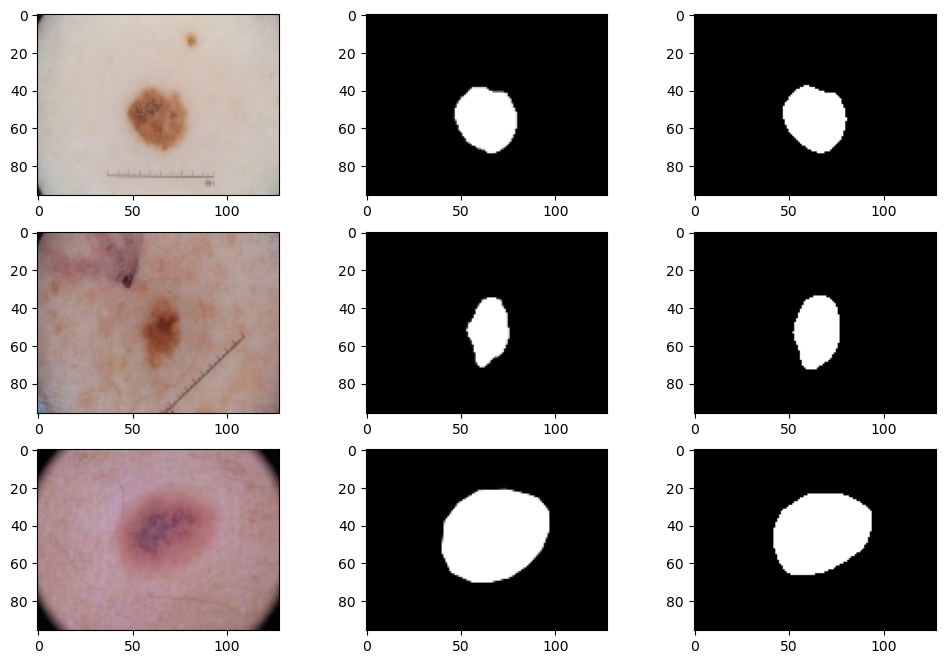

In [38]:
features, targets = next(iter(dl_test))
features = features.to(device)
targets = targets.to(device)
predicts = model(features)[-1]

plt.figure(figsize=(12,8))
i = 0
for f,t,p in zip(features[:3],targets[:3],predicts[:3]):
    f = f.detach().cpu().numpy().transpose(1,2,0)
    t = t.squeeze().detach().cpu().numpy()
    p = p.squeeze().detach().cpu().numpy()
    p[np.nonzero(p < 0.48)] = 0.0
    p[np.nonzero(p >= 0.48)] = 1.0
    
    plt.subplot(3,3,i+1)
    plt.imshow(f)
    plt.subplot(3,3,i+2)
    plt.imshow(t,cmap='gray')
    plt.subplot(3,3,i+3)
    plt.imshow(p,cmap='gray')
    i+=3
plt.show()

## impressions
> The development of medical image data segmentation is now very mature, the focus is on how to explain his rationality, the future can work towards this direction

> Doing these experiments, I can very much feel the difference between the size of the segmentation dataset and the target detection and image recognition dataset, and in the future, doing experiments on medical images can be towards semi-supervised and unsupervised aspects